In [1]:

import glob
import time
import os
import pandas as pd
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
import pickle
from argparse import ArgumentParser, Namespace
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from itertools import chain
from tqdm import tqdm
import copy
import shutil
import pickle
import json

In [2]:
dev_feature_set = 'SemTabRound4_T2DV2_train//dev-output/v26/features/'
positive_features_path = 'positive_features_total.pkl'
negative_features_path = 'negative_features_total.pkl'

output_path = 'feature_model/'
num_of_epochs = 15
learning_rates = [0.01, 0.001]

final_score_column = 'siamese_prediction'

In [3]:
positive_features = pickle.load(open(positive_features_path, 
                                    'rb'))

In [12]:
len(positive_features)

454185

In [9]:
uniques = []
for i in positive_features:
    
    

TypeError: unhashable type: 'list'

In [3]:
!mkdir -p {output_path}

In [3]:
# Deciding up the features
# All the features 
features = ["monge_elkan","monge_elkan_aliases","jaro_winkler",
            "levenshtein","singleton","context_score_3","pgt_centroid_score","pgt_class_count_tf_idf_score",
            "pgt_property_count_tf_idf_score", "num_occurences", "incorrectness_scores"]
string_similarity_features = ["monge_elkan","monge_elkan_aliases","jaro_winkler", "levenshtein"]
semantic_features = ["singleton","context_score_3","pgt_centroid_score","pgt_class_count_tf_idf_score",
            "pgt_property_count_tf_idf_score", "num_occurences", "incorrectness_scores"]
extra_feature_exp_1 = ["monge_elkan","monge_elkan_aliases","jaro_winkler", "levenshtein", "context_score_3"]
extra_feature_exp_2 = ["monge_elkan","monge_elkan_aliases","jaro_winkler", "levenshtein", "context_score_3", "pgt_class_count_tf_idf_score",
                       "pgt_property_count_tf_idf_score"]
extra_feature_exp_3 = ["monge_elkan","monge_elkan_aliases", "levenshtein", "context_score_3", "pgt_class_count_tf_idf_score",
                       "pgt_property_count_tf_idf_score"]
experiment_feature_list = [string_similarity_features, semantic_features, extra_feature_exp_1, extra_feature_exp_2, extra_feature_exp_3]

In [5]:
# Create a dataframe with this as list and add the min_max_scaler

In [6]:
# For now apply min_max_scaler only on num_occurences


In [4]:
class T2DV2Dataset(Dataset):
    def __init__(self, pos_features, neg_features):
        #print(type(pos_features), type(neg_features))
        self.pos_features = pos_features
        self.neg_features = neg_features
        # self.transform = transforms.Compose([transforms.ToTensor()])  
    
    def __len__(self):
        #print(type(len(self.pos_features)))
        return min(len(self.pos_features), len(self.neg_features))
    
    def __getitem__(self, idx):
        # print("here", (self.pos_features[idx]), (self.neg_features[idx]))
        return self.pos_features[idx], self.neg_features[idx]

# Model
class PairwiseNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        #original 12x24, 24x12, 12x12, 12x1
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.fc2 = nn.Linear(hidden_size*2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
    
    def forward(self, pos_features, neg_features):
        # Positive pass
        x = F.relu(self.fc1(pos_features))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        pos_out = torch.sigmoid(self.fc4(x))
        
        # Negative Pass
        x = F.relu(self.fc1(neg_features))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        neg_out = torch.sigmoid(self.fc4(x))
        
        return pos_out, neg_out
    
    def predict(self, test_feat):
        x = F.relu(self.fc1(test_feat))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        test_out = torch.sigmoid(self.fc4(x))
        return test_out

# Pairwise Loss
class PairwiseLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = 0
    
    def forward(self, pos_out, neg_out):
        distance = (1 - pos_out) + neg_out
        loss = torch.mean(torch.max(torch.tensor(0), distance))
        return loss

In [5]:
def data_creator(positive_feature_path, negative_feature_path, curr_features):
    positive_feature_set = []
    negative_feature_set = []
    # Defining feature_true
    feature_true = [0] * len(features)
    for i in range(len(features)):
        if features[i] in curr_features:
            feature_true[i] = 1
    p_feat_load = pickle.load(open(positive_feature_path, "rb"))
    n_feat_load = pickle.load(open(negative_feature_path, "rb"))
    for i in p_feat_load:

        singular_feature_list = []
        list_features = i[-1]
        for j in range(len(list_features)):
            if feature_true[j]:
                singular_feature_list.append(list_features[j])
        positive_feature_set.append(np.array(singular_feature_list))
    for i in n_feat_load:
        singular_feature_list = []
        list_features = i[-1]
        for j in range(len(list_features)):
            if feature_true[j]:
                singular_feature_list.append(list_features[j])
        negative_feature_set.append(np.array(singular_feature_list))
    print(positive_feature_set[0], negative_feature_set[0])
    print(len(positive_feature_set), len(negative_feature_set))
    return positive_feature_set, negative_feature_set

In [6]:
def generate_dataloader(positive_feature_set, negative_feature_set):      
    pos_features_flatten = np.array(positive_feature_set)
    neg_features_flatten = np.array(negative_feature_set)
    print(pos_features_flatten.shape, neg_features_flatten.shape)
    #print(type(pos_features_flatten), neg_features_flatten[0], type(neg_features_flatten[0]))     
    train_dataset = T2DV2Dataset(pos_features_flatten, neg_features_flatten)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle = False)
    return train_dataloader

def infer_scores(min_max_scaler_path, input_table_path, output_table_path, model):
    # scaler = pickle.load(open(min_max_scaler_path, 'rb'))
    normalize_features = curr_features
    for file in glob.glob(input_table_path + '/*.csv'):
        file_name = file.split('/')[-1]
        if os.path.getsize(file) == 0:
                continue
                
        d_sample = pd.read_csv(file)
#         d_sample['context_score'].fillna(0.0, inplace=True)
        grouped_obj = d_sample.groupby(['column', 'row'])
        new_df_list = []
        pred = []
        for cell in grouped_obj:
            # cell[1][normalize_features] = scaler.transform(cell[1][normalize_features])
            sorted_df = cell[1].sort_values('context_score', ascending=False)
            sorted_df_features = sorted_df[normalize_features]
            new_df_list.append(sorted_df)
            arr = sorted_df_features.to_numpy()
            test_inp = []
            for a in arr:
                test_inp.append(a)
            test_tensor = torch.tensor(test_inp).float()
            scores = model.predict(test_tensor)
            scores_list = torch.squeeze(scores).tolist()
            if not type(scores_list) is list:
                pred.append(scores_list)
            else:
                pred.extend(scores_list)
        test_df = pd.concat(new_df_list)
        test_df[final_score_column] = pred
        test_df.to_csv(f"{output_table_path}/{file_name}", index=False)

def train(args):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    
    else:
        device = torch.device('cpu')
    device = torch.device('cpu')
    use_scheduler = False
    train_dataloader = generate_dataloader(args.positive_feat_path, args.negative_feat_path)
    criterion = PairwiseLoss()
    EPOCHS = args.num_epochs
    model = PairwiseNetwork(len(curr_features)).to(device=device)
    optimizer = Adam(model.parameters(), lr=args.lr)
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)
    top1_max_prec = 0
    for epoch in range(EPOCHS):
        train_epoch_loss = 0
        avg_loss = 0
        model.train()
        for bid, batch in tqdm(enumerate(train_dataloader), position=0, leave=True):
            # print("--------------")
            positive_feat = torch.tensor(batch[0].float())
            negative_feat = torch.tensor(batch[1].float())
            optimizer.zero_grad()
            pos_out, neg_out = model(positive_feat, negative_feat)
            loss = criterion(pos_out, neg_out)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss
        avg_loss = train_epoch_loss / bid
        if use_scheduler:
            scheduler.step()
        # Evaluation
        model.eval()
        infer_scores(args.min_max_scaler_path, args.dev_path, args.dev_output, model)
        eval_data = merge_eval_files(args.dev_output)
        res, candidate_eval_data = parse_eval_files_stats(eval_data, final_score_column)
        top1_precision = res['num_tasks_with_model_score_top_one_accurate']/res['num_tasks_with_gt']
        if top1_precision >= top1_max_prec:
            top1_max_prec = top1_precision
            model_save_name = 'scheduler_{}_lr_{}_epoch_{}_loss_{}_top1_{}.pth'.format(use_scheduler, args.lr, epoch, avg_loss, top1_max_prec)
            best_model_path = os.path.join(args.model_save_path, model_save_name)
            torch.save(model.state_dict(), best_model_path)
        
        print("Epoch {}, Avg Loss is {}, epoch top1 {}, max top1 {}".format(epoch, avg_loss, top1_precision, top1_max_prec))
    return best_model_path

In [7]:
def merge_eval_files(final_score_path):
    eval_file_names = []
    df_list = []
    for (dirpath, dirnames, filenames) in os.walk(final_score_path):
        for fn in filenames:
            if "csv" not in fn:
                continue
            abs_fn = os.path.join(dirpath, fn)
            assert os.path.isfile(abs_fn)
            if os.path.getsize(abs_fn) == 0:
                continue
            eval_file_names.append(abs_fn)
    
    for fn in eval_file_names:
        fid = fn.split('/')[-1].split('.csv')[0]
        # print(fn)
        df = pd.read_csv(fn)
        df['table_id'] = fid
        df_list.append(df)
    return pd.concat(df_list)

def parse_eval_files_stats(eval_data, method):
    res = {}
    candidate_eval_data = eval_data.groupby(['table_id', 'column', 'row'])['table_id'].count().reset_index(name="count")
    res['num_tasks_with_gt'] = len(eval_data[pd.notna(eval_data['GT_kg_id'])].groupby(['table_id', 'column', 'row']))
    num_tasks_with_model_score_top_one_accurate = []
    num_tasks_with_model_score_top_five_accurate = []
    num_tasks_with_model_score_top_ten_accurate = []
    has_gt_list = []
    has_gt_in_candidate = []
    for i, row in candidate_eval_data.iterrows():
        table_id, row_idx, col_idx = row['table_id'], row['row'], row['column']
        c_e_data = eval_data[(eval_data['table_id'] == table_id) & (eval_data['row'] == row_idx) & (eval_data['column'] == col_idx)]
        assert len(c_e_data) > 0
        if np.nan not in set(c_e_data['GT_kg_id']):
            has_gt_list.append(1)
        else:
            has_gt_list.append(0)
        if 1 in set(c_e_data['evaluation_label']):
            has_gt_in_candidate.append(1)
        else:
            has_gt_in_candidate.append(0)
                    
        #rank on model score
        s_data = c_e_data.sort_values(by=[method], ascending=False)
        if s_data.iloc[0]['evaluation_label'] == 1:
            num_tasks_with_model_score_top_one_accurate.append(1)
        else:
            num_tasks_with_model_score_top_one_accurate.append(0)
        if 1 in set(s_data.iloc[0:5]['evaluation_label']):
            num_tasks_with_model_score_top_five_accurate.append(1)
        else:
            num_tasks_with_model_score_top_five_accurate.append(0)
        if 1 in set(s_data.iloc[0:10]['evaluation_label']):
            num_tasks_with_model_score_top_ten_accurate.append(1)
        else:
            num_tasks_with_model_score_top_ten_accurate.append(0)
            
    res['num_tasks_with_model_score_top_one_accurate'] = sum(num_tasks_with_model_score_top_one_accurate)
    res['num_tasks_with_model_score_top_five_accurate'] = sum(num_tasks_with_model_score_top_five_accurate)
    res['num_tasks_with_model_score_top_ten_accurate'] = sum(num_tasks_with_model_score_top_ten_accurate)
    return res, candidate_eval_data

In [23]:
curr_features = features
positive_feature_set, negative_feature_set = data_creator(positive_features_path, negative_features_path, curr_features)

[0.         1.         0.         0.         0.         0.
 0.64788039 0.2114032  0.32691692 1.         0.5       ] [0.72103175 0.60103175 0.70726496 0.53846154 0.         0.
 0.54664618 0.12153565 0.03171066 2.         0.        ]
454185 454185


In [39]:
positive_feature_set[0]

array([0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.64788039, 0.2114032 , 0.32691692, 1.        ,
       0.5       ])

In [51]:
len(positive_feature_set)

454185

In [52]:
j = np.array(positive_feature_set).reshape(454185, 11)

In [62]:
k = np.unique(j, axis = 0)

In [63]:
k[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.69886941, 1.        , 0.87269058, 1.        ,
       0.5       ])

In [41]:
pk[0]

-0.0562367664705944

In [65]:
training_args = Namespace(num_epochs=20, lr=0.001, positive_feat_path=k, negative_feat_path=negative_feature_set,
                         dev_path=dev_feature_set, dev_output='Experiment_5/',
                         model_save_path='_rn', min_max_scaler_path=None)

ERROR! Session/line number was not unique in database. History logging moved to new session 1198


In [66]:
best_model_path = train(training_args)

0it [00:00, ?it/s]<ipython-input-33-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_feat = torch.tensor(batch[0].float())
<ipython-input-33-c56c4f869aac>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_feat = torch.tensor(batch[1].float())
55it [00:00, 540.89it/s]

(21184, 11) (454185, 11)


662it [00:01, 531.77it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-33-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_feat = torch.tensor(batch[0].float())
<ipython-input-33-c56c4f869aac>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_feat = torch.tensor(batch[1].float())
41it [00:00, 404.25it/s]

Epoch 0, Avg Loss is 0.4088764488697052, epoch top1 0.7830756013745704, max top1 0.7830756013745704


662it [00:01, 512.61it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-33-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1, Avg Loss is 0.2318940907716751, epoch top1 0.7010309278350515, max top1 0.7830756013745704


662it [00:01, 528.58it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-33-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 2, Avg Loss is 0.22526444494724274, epoch top1 0.6709621993127147, max top1 0.7830756013745704


662it [00:01, 420.71it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyboardInterrupt: 

In [10]:
import json

In [11]:
len(experiment_feature_list)

5

In [18]:
best_model_paths_experiment = {}
ignore = 4
for experiment in experiment_feature_list:
    if ignore > 0:
        ignore = ignore - 1
        continue
    curr_features = experiment
    pos_feature_set, neg_feature_set = data_creator(positive_features_path, negative_features_path, curr_features)
    feature_version = "Experiment_" + str(experiment_feature_list.index(experiment)) + '/'
    save_model = output_path + feature_version + "saved_models/"
    dev_predictions = output_path + feature_version + "dev_predictions/"
    !mkdir -p {feature_version}
    !mkdir -p {save_model}
    !mkdir -p {dev_predictions}
    # for l_rate in learning_rates:
    training_args = Namespace(num_epochs=20, lr=0.00005, positive_feat_path=pos_feature_set, negative_feat_path=neg_feature_set,
                         dev_path=dev_feature_set, dev_output=dev_predictions,
                         model_save_path=save_model, min_max_scaler_path=None)
    best_model_path = train(training_args)
    best_model_paths_experiment[f"{feature_version}_0.0001"] = best_model_path
    json.dump(best_model_paths_experiment, open('experiments_result.json', "w"))

[0.         1.         0.         0.         0.         0.
 0.64788039 0.2114032  0.32691692 1.         0.5       ] [0.72103175 0.60103175 0.70726496 0.53846154 0.         0.
 0.54664618 0.12153565 0.03171066 2.         0.        ]


0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_feat = torch.tensor(batch[0].float())
<ipython-input-9-c56c4f869aac>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_feat = torch.tensor(batch[1].float())
53it [00:00, 521.85it/s]

(454185, 11) (454185, 11)


14194it [00:26, 536.62it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]

Epoch 0, Avg Loss is 0.4000122547149658, epoch top1 0.947594501718213, max top1 0.947594501718213


<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_feat = torch.tensor(batch[0].float())
<ipython-input-9-c56c4f869aac>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_feat = torch.tensor(batch[1].float())
14194it [00:26, 532.37it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Speci

Epoch 1, Avg Loss is 0.3244779706001282, epoch top1 0.9518900343642611, max top1 0.9518900343642611


14194it [00:25, 559.08it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

Epoch 2, Avg Loss is 0.3202381134033203, epoch top1 0.9527491408934707, max top1 0.9527491408934707


14194it [00:29, 479.92it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

Epoch 3, Avg Loss is 0.31826603412628174, epoch top1 0.9536082474226805, max top1 0.9536082474226805


14194it [00:26, 544.21it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

Epoch 4, Avg Loss is 0.31731924414634705, epoch top1 0.9531786941580757, max top1 0.9536082474226805


14194it [00:28, 505.35it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

Epoch 5, Avg Loss is 0.3164729177951813, epoch top1 0.9540378006872853, max top1 0.9540378006872853


14194it [00:27, 525.53it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 6, Avg Loss is 0.3156006336212158, epoch top1 0.9553264604810997, max top1 0.9553264604810997


0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_feat = torch.tensor(batch[0].float())
<ipython-input-9-c56c4f869aac>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_feat = torch.tensor(batch[1].float())
14194it [00:25, 555.97it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have

Epoch 7, Avg Loss is 0.3145926594734192, epoch top1 0.9548969072164949, max top1 0.9553264604810997


14194it [00:25, 564.20it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
0it [00:00, ?it/s]<ipython-input-9-c56c4f869aac>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

Epoch 8, Avg Loss is 0.3135864734649658, epoch top1 0.9553264604810997, max top1 0.9553264604810997


14194it [00:26, 544.74it/s]
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 9, Avg Loss is 0.3128686249256134, epoch top1 0.9548969072164949, max top1 0.9553264604810997


In [27]:
print ("List in proper method", '[%s]' % ', '.join(map(str, features)))

List in proper method [monge_elkan, monge_elkan_aliases, jaro_winkler, levenshtein, singleton, context_score_3, pgt_centroid_score, pgt_class_count_tf_idf_score, pgt_property_count_tf_idf_score, num_occurences, incorrectness_scores]


In [8]:
merged_files = None
def top_k_and_add_color(saved_model, features, dev_features_path, dev_top_k_path, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics):
    file_list = glob.glob(dev_features_path + '*.csv')
    min_max_scaler_path = "tl_pipeline_normalization_factor.pkl"
    df_list = []
    feature_str = ",".join(features)
    for file in file_list:
        # Predicting
        filename = file.split('/')[-1]
        print(filename)
        pred_file = dev_predictions_path + filename
        print(os.path.exists(dev_predictions_path), pred_file)
        top_5_file = dev_top_k_path + filename
        color_file = dev_colorized + filename.replace('.csv', '.xlsx')
        metrics_file = dev_metrics_path + filename
        !tl predict-using-model $file -o $final_score_column \
        --features $feature_str \
        --ranking-model $saved_model \
        --normalization-factor $min_max_scaler_path > $pred_file
        merged_files = merge_eval_files(dev_predictions_path)
        !tl get-kg-links $pred_file --k-rows -k 5 -c $final_score_column > $top_5_file
        !tl add-color $top_5_file -k 5 -c $final_score_column,evaluation_label --output $color_file
        !tl metrics $top_5_file -k 1 -c $final_score_column --tag $filename> $metrics_file
        if os.path.getsize(metrics_file) > 2:
            df = pd.read_csv(metrics_file)
            df_list.append(df)
        #get the top 5
        # colorize
    return pd.concat(df_list)

In [13]:
#All features
feature_version = 'Experiment_5/'
curr_features = features
saved_model = 'feature_model/Experiment_5/saved_models/scheduler_False_lr_0.0001_epoch_8_loss_0.3135864734649658_top1_0.9553264604810997.pth'
dev_predictions_path = output_path + feature_version + 'dev_predictions/'
dev_predictions_top_k = output_path + feature_version + 'dev_predictions_top_k/'
dev_colorized = output_path + feature_version + 'dev_predictions_colorized/'
dev_metrics_path = output_path + feature_version + 'dev_metrics/'
final_score_column = 'siamese_prediction'
!mkdir -p $dev_predictions_path
!mkdir -p $dev_predictions_top_k
!mkdir -p $dev_colorized
!mkdir -p $dev_metrics_path


In [14]:
dev_predictions_path

'feature_model/Experiment_5/dev_predictions/'

In [31]:
metrics_df = top_k_and_add_color(saved_model, curr_features, dev_feature_set, dev_predictions_top_k, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics_path)

0CETTKTA.csv
True feature_model/Experiment_5/dev_predictions/0CETTKTA.csv
predict-using-model Time: 3.332609176635742s
get-kg-links-siamese_prediction Time: 0.18154621124267578s
add-color Time: 0.2581980228424072s
metrics Time: 0.07976818084716797s
2E6QBLCA.csv
True feature_model/Experiment_5/dev_predictions/2E6QBLCA.csv
predict-using-model Time: 1.4089138507843018s
get-kg-links-siamese_prediction Time: 0.3766336441040039s
add-color Time: 0.18762993812561035s
metrics Time: 0.18978476524353027s
29D1VZHF.csv
True feature_model/Experiment_5/dev_predictions/29D1VZHF.csv
predict-using-model Time: 2.1484029293060303s
get-kg-links-siamese_prediction Time: 0.5128324031829834s
add-color Time: 0.24450898170471191s
metrics Time: 0.2597193717956543s
2FXR6BX7.csv
True feature_model/Experiment_5/dev_predictions/2FXR6BX7.csv
predict-using-model Time: 3.295865774154663s
get-kg-links-siamese_prediction Time: 0.6033022403717041s
add-color Time: 0.23527908325195312s
metrics Time: 0.28812336921691895s
53O

In [9]:
merged_files = merge_eval_files('feature_model/Experiment_5/dev_predictions/')

/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


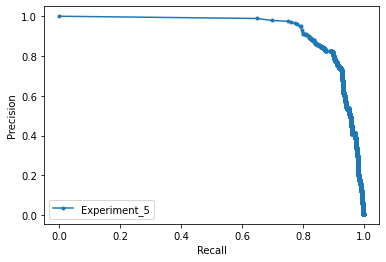

In [10]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
testy = merged_files['evaluation_label'].replace({-1:0})
lr_probs = merged_files['siamese_prediction']
lr_precision, lr_recall, _ = precision_recall_curve(testy.ravel(), lr_probs.ravel())
# , lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Experiment_5')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

Best Threshold=0.385917, G-Mean=0.983


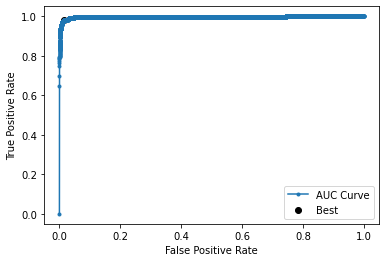

In [11]:
from numpy import sqrt, argmax
fpr, tpr, thresholds = roc_curve(testy, lr_probs)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot(fpr, tpr, marker='.', label='AUC Curve')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [17]:
merged_files

,column,row,label,context,filename,column-id,label_clean,kg_id,kg_labels,kg_aliases,...,num_char,num_tokens,is_lof,pgt_centroid_score,pgt_class_count_tf_idf_score,top5_class_count,pgt_property_count_tf_idf_score,top5_property_count,siamese_prediction,table_id
0,0,0,iron-5m,26.208|1.1088,4DPRZWVL.csv,4DPRZWVL.csv-0,iron-5m,Q18880100,fer 65m|iron-65m,65mFe|Fe-65m,...,16,2,1,0.977943,1.000000,Q1201493:0.085|Q677:0.083|Q2512777:0.072|Q2527...,0.744427,P1123:0.121|P1122:0.121|P2114:0.120|P816:0.119...,9.994487e-01,4DPRZWVL
1,0,0,iron-5m,26.208|1.1088,4DPRZWVL.csv,4DPRZWVL.csv-0,iron-5m,Q1052454,fer 56|hierro-56|iron-56|ferro-56|Eisen-56,"Fe-56|/m/0br4x3|iron-56|Fe|Entity[\Isotope\, \...",...,42,2,-1,0.887212,0.833663,Q1201493:0.085|Q677:0.083|Q2512777:0.072|Q2527...,0.761704,P1123:0.121|P1122:0.121|P1148:0.116|P1086:0.11...,9.460697e-01,4DPRZWVL
2,0,0,iron-5m,26.208|1.1088,4DPRZWVL.csv,4DPRZWVL.csv-0,iron-5m,Q14646208,Eisen-52|fer 52|iron-52|ferro-52,"52Fe|Entity[\Isotope\, \Iron52\]|52 |Fe-52",...,32,2,-1,0.868728,0.833663,Q1201493:0.085|Q677:0.083|Q2512777:0.072|Q2527...,1.000000,P1123:0.121|P1122:0.121|P2114:0.120|P816:0.119...,1.464469e-02,4DPRZWVL
3,0,0,iron-5m,26.208|1.1088,4DPRZWVL.csv,4DPRZWVL.csv-0,iron-5m,Q14646209,fer 53|iron-53|Eisen-53|ferro-53,"Fe-53|53Fe|Entity[\Isotope\, \Iron53\]",...,32,2,-1,0.897157,0.833663,Q1201493:0.085|Q677:0.083|Q2512777:0.072|Q2527...,1.000000,P1123:0.121|P1122:0.121|P2114:0.120|P816:0.119...,9.792144e-03,4DPRZWVL
4,0,0,iron-5m,26.208|1.1088,4DPRZWVL.csv,4DPRZWVL.csv-0,iron-5m,Q14744877,fer 57|Eisen-57|hierro-57|iron-57|ferro-57,57Fe|Fe-57|<sup>57</sup>Fe|iron-57|Iron-57|Ent...,...,42,2,-1,0.910479,0.833663,Q1201493:0.085|Q677:0.083|Q2512777:0.072|Q2527...,0.761704,P1123:0.121|P1122:0.121|P1148:0.116|P1086:0.11...,9.244817e-01,4DPRZWVL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120,2,9,camera phone,Nokia 5235|70,2E6QBLCA.csv,2E6QBLCA.csv-2,camera phone,Q90274221,William de Camera,"Camera, W. D. |W. de Camera|William D. Camera|...",...,17,3,-1,0.351810,0.073973,Q1047113:0.011|Q9081:0.011|Q104127086:0.011|Q1...,-0.000545,P21:0.000|P27:0.000|P39:0.000|P735:0.000|P31:-...,1.493239e-07,2E6QBLCA
5121,2,9,camera phone,Nokia 5235|70,2E6QBLCA.csv,2E6QBLCA.csv-2,camera phone,Q17150595,Love Is a Camera,/m/010r6mtd|5776206|Love is a Camera|Love Is a...,...,16,4,-1,0.559240,0.136263,Q3958441:0.016|Q336:0.015|Q11862829:0.012|Q104...,0.033067,P156:0.010|P155:0.010|P577:0.008|P646:0.006|P1...,5.025785e-08,2E6QBLCA
5122,2,9,camera phone,Nokia 5235|70,2E6QBLCA.csv,2E6QBLCA.csv-2,camera phone,Q6058054,I Am a Camera,/m/0274l8r|i-am-a-camera-lyrics-buggles|I Am A...,...,13,4,-1,0.545377,0.136263,Q3958441:0.016|Q336:0.015|Q11862829:0.012|Q104...,0.033067,P156:0.010|P155:0.010|P577:0.008|P646:0.006|P1...,5.348319e-08,2E6QBLCA
5123,2,9,camera phone,Nokia 5235|70,2E6QBLCA.csv,2E6QBLCA.csv-2,camera phone,Q210820,camera phone,cell phone photo|Cameraphone|Phonecamera|video...,...,12,2,-1,0.654909,0.399895,Q17517:0.032|Q5082128:0.031|Q11035:0.030|Q5811...,0.062541,P8408:0.019|P2581:0.017|P279:0.007|P373:0.007|...,5.707999e-01,2E6QBLCA


In [32]:
metrics_df.to_csv(dev_metrics_path + "metrics_1.csv", index = False)

In [ ]:
pos_feature_set[:10]

In [15]:
#All features
feature_version = 'Experiment_0/'
curr_features = experiment_feature_list[0]
saved_model = 'feature_model/Experimentf_0/saved_models/scheduler_False_lr_5e-05_epoch_4_loss_0.4877758026123047_top1_0.8526632302405498.pth'
dev_predictions_path = output_path + feature_version + 'dev_predictions/'
dev_predictions_top_k = output_path + feature_version + 'dev_predictions_top_k/'
dev_colorized = output_path + feature_version + 'dev_predictions_colorized/'
dev_metrics_path = output_path + feature_version + 'dev_metrics/'
final_score_column = 'siamese_prediction'
!mkdir -p $dev_predictions_path
!mkdir -p $dev_predictions_top_k
!mkdir -p $dev_colorized
!mkdir -p $dev_metrics_path
metrics_df = top_k_and_add_color(saved_model, curr_features, dev_feature_set, dev_predictions_top_k, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics_path)
metrics_df.to_csv(dev_metrics_path + "metrics_1.csv", index = False)

0CETTKTA.csv
True feature_model/Experiment_0/dev_predictions/0CETTKTA.csv
predict-using-model Time: 3.2482519149780273s
get-kg-links-siamese_prediction Time: 0.5788123607635498s
add-color Time: 0.45508837699890137s
metrics Time: 0.20576715469360352s
2E6QBLCA.csv
True feature_model/Experiment_0/dev_predictions/2E6QBLCA.csv
predict-using-model Time: 2.2794647216796875s
get-kg-links-siamese_prediction Time: 0.7483980655670166s
add-color Time: 0.47511792182922363s
metrics Time: 0.36243438720703125s
29D1VZHF.csv
True feature_model/Experiment_0/dev_predictions/29D1VZHF.csv
predict-using-model Time: 2.126075267791748s
get-kg-links-siamese_prediction Time: 1.132673740386963s
add-color Time: 0.6068651676177979s
metrics Time: 0.4392101764678955s
2FXR6BX7.csv
True feature_model/Experiment_0/dev_predictions/2FXR6BX7.csv
predict-using-model Time: 2.470524549484253s
get-kg-links-siamese_prediction Time: 1.6597883701324463s
add-color Time: 0.5137591361999512s
metrics Time: 0.8148491382598877s
53OUTCE

/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


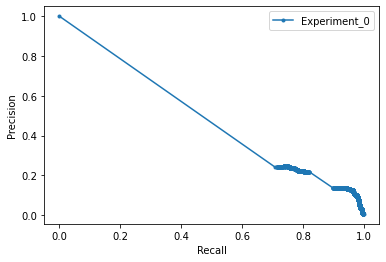

Best Threshold=0.467766, G-Mean=0.961


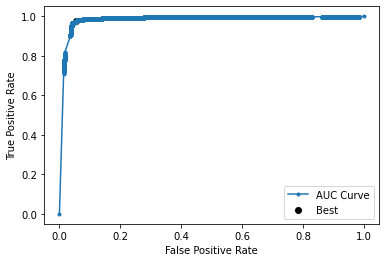

In [17]:
merged_files = merge_eval_files('feature_model/Experiment_0/dev_predictions/')
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
testy = merged_files['evaluation_label'].replace({-1:0})
lr_probs = merged_files['siamese_prediction']
lr_precision, lr_recall, _ = precision_recall_curve(testy.ravel(), lr_probs.ravel())
# , lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Experiment_0')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()
from numpy import sqrt, argmax
fpr, tpr, thresholds = roc_curve(testy, lr_probs)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot(fpr, tpr, marker='.', label='AUC Curve')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [16]:
#All features
feature_version = 'Experiment_1/'
curr_features = experiment_feature_list[1]
saved_model = 'feature_model/Experiment_1/saved_models/scheduler_False_lr_0.0001_epoch_1_loss_0.33893075585365295_top1_0.9493127147766323.pth'
dev_predictions_path = output_path + feature_version + 'dev_predictions/'
dev_predictions_top_k = output_path + feature_version + 'dev_predictions_top_k/'
dev_colorized = output_path + feature_version + 'dev_predictions_colorized/'
dev_metrics_path = output_path + feature_version + 'dev_metrics/'
final_score_column = 'siamese_prediction'
!mkdir -p $dev_predictions_path
!mkdir -p $dev_predictions_top_k
!mkdir -p $dev_colorized
!mkdir -p $dev_metrics_path
metrics_df = top_k_and_add_color(saved_model, curr_features, dev_feature_set, dev_predictions_top_k, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics_path)
metrics_df.to_csv(dev_metrics_path + "metrics_1.csv", index = False)

0CETTKTA.csv
True feature_model/Experiment_1/dev_predictions/0CETTKTA.csv
predict-using-model Time: 2.3923561573028564s
get-kg-links-siamese_prediction Time: 0.3849484920501709s
add-color Time: 0.3363220691680908s
metrics Time: 0.14985442161560059s
2E6QBLCA.csv
True feature_model/Experiment_1/dev_predictions/2E6QBLCA.csv
predict-using-model Time: 2.089045524597168s
get-kg-links-siamese_prediction Time: 0.8307502269744873s
add-color Time: 0.32142019271850586s
metrics Time: 0.40329480171203613s
29D1VZHF.csv
True feature_model/Experiment_1/dev_predictions/29D1VZHF.csv
predict-using-model Time: 2.1651804447174072s
get-kg-links-siamese_prediction Time: 1.2582557201385498s
add-color Time: 0.403339147567749s
metrics Time: 0.5518407821655273s
2FXR6BX7.csv
True feature_model/Experiment_1/dev_predictions/2FXR6BX7.csv
predict-using-model Time: 2.3106675148010254s
get-kg-links-siamese_prediction Time: 1.769784927368164s
add-color Time: 0.6839048862457275s
metrics Time: 0.77130126953125s
53OUTCE4.c

/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


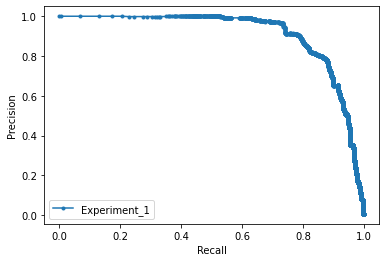

Best Threshold=0.523209, G-Mean=0.977


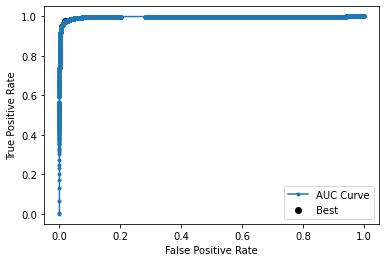

In [16]:
merged_files = merge_eval_files('feature_model/Experiment_1/dev_predictions/')
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
testy = merged_files['evaluation_label'].replace({-1:0})
lr_probs = merged_files['siamese_prediction']
lr_precision, lr_recall, _ = precision_recall_curve(testy.ravel(), lr_probs.ravel())
# , lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Experiment_1')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()
from numpy import sqrt, argmax
fpr, tpr, thresholds = roc_curve(testy, lr_probs)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot(fpr, tpr, marker='.', label='AUC Curve')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
#All features
feature_version = 'Experiment_2/'
curr_features = experiment_feature_list[2]
saved_model = 'feature_model/Experiment_2/saved_models/scheduler_False_lr_0.0001_epoch_4_loss_0.3986770808696747_top1_0.9407216494845361.pth'
dev_predictions_path = output_path + feature_version + 'dev_predictions/'
dev_predictions_top_k = output_path + feature_version + 'dev_predictions_top_k/'
dev_colorized = output_path + feature_version + 'dev_predictions_colorized/'
dev_metrics_path = output_path + feature_version + 'dev_metrics/'
final_score_column = 'siamese_prediction'
!mkdir -p $dev_predictions_path
!mkdir -p $dev_predictions_top_k
!mkdir -p $dev_colorized
!mkdir -p $dev_metrics_path
metrics_df = top_k_and_add_color(saved_model, curr_features, dev_feature_set, dev_predictions_top_k, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics_path)
metrics_df.to_csv(dev_metrics_path + "metrics_1.csv", index = False)

0CETTKTA.csv
True feature_model/Experiment_2/dev_predictions/0CETTKTA.csv
predict-using-model Time: 2.38728928565979s
get-kg-links-siamese_prediction Time: 0.5535478591918945s
add-color Time: 0.2631034851074219s
metrics Time: 0.1934196949005127s
2E6QBLCA.csv
True feature_model/Experiment_2/dev_predictions/2E6QBLCA.csv
predict-using-model Time: 3.6499245166778564s
get-kg-links-siamese_prediction Time: 0.9281034469604492s
add-color Time: 0.23736834526062012s
metrics Time: 0.30437302589416504s
29D1VZHF.csv
True feature_model/Experiment_2/dev_predictions/29D1VZHF.csv
predict-using-model Time: 1.9363048076629639s
get-kg-links-siamese_prediction Time: 1.6534290313720703s
add-color Time: 0.4402942657470703s
metrics Time: 0.5147294998168945s
2FXR6BX7.csv
True feature_model/Experiment_2/dev_predictions/2FXR6BX7.csv
predict-using-model Time: 2.2690224647521973s
get-kg-links-siamese_prediction Time: 2.1170759201049805s
add-color Time: 0.5243716239929199s
metrics Time: 0.5473644733428955s
53OUTCE4

/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


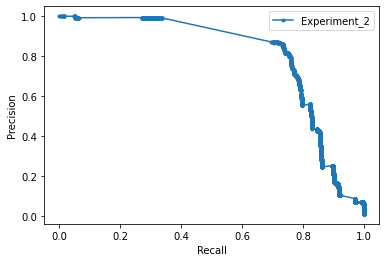

Best Threshold=0.256203, G-Mean=0.957


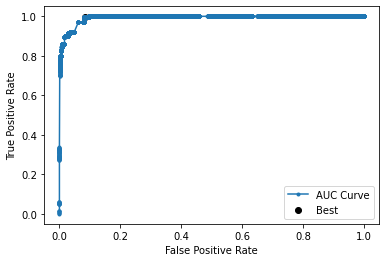

In [15]:
merged_files = merge_eval_files('feature_model/Experiment_2/dev_predictions/')
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
testy = merged_files['evaluation_label'].replace({-1:0})
lr_probs = merged_files['siamese_prediction']
lr_precision, lr_recall, _ = precision_recall_curve(testy.ravel(), lr_probs.ravel())
# , lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Experiment_2')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()
from numpy import sqrt, argmax
fpr, tpr, thresholds = roc_curve(testy, lr_probs)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot(fpr, tpr, marker='.', label='AUC Curve')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [25]:
df = pd.read_csv('feature_model/Experiment_5/dev_metrics/metrics_1.csv')
df.head()

,k,f1,precision,recall,column,tag
0,1,1.00,1.00,1.00,0,0CETTKTA.csv
1,1,0.95,0.95,0.95,0,2E6QBLCA.csv
2,1,0.85,0.85,0.85,2,2E6QBLCA.csv
3,1,1.00,1.00,1.00,0,29D1VZHF.csv
4,1,1.00,1.00,1.00,1,29D1VZHF.csv


In [28]:
df['f1'].mean()

0.964339581422915

In [20]:
#All features
feature_version = 'Experiment_4/'
curr_features = experiment_feature_list[4]
saved_model = 'feature_model/Experimentf_4/saved_models/scheduler_False_lr_5e-05_epoch_8_loss_0.3923964202404022_top1_0.959192439862543.pth'
dev_predictions_path = output_path + feature_version + 'dev_predictions/'
dev_predictions_top_k = output_path + feature_version + 'dev_predictions_top_k/'
dev_colorized = output_path + feature_version + 'dev_predictions_colorized/'
dev_metrics_path = output_path + feature_version + 'dev_metrics/'
final_score_column = 'siamese_prediction'
!mkdir -p $dev_predictions_path
!mkdir -p $dev_predictions_top_k
!mkdir -p $dev_colorized
!mkdir -p $dev_metrics_path
metrics_df = top_k_and_add_color(saved_model, curr_features, dev_feature_set, dev_predictions_top_k, dev_metrics_path, 
                        dev_predictions_path, dev_colorized, final_score_column, dev_metrics_path)
metrics_df.to_csv(dev_metrics_path + "metrics_1.csv", index = False)

0CETTKTA.csv
True feature_model/Experiment_4/dev_predictions/0CETTKTA.csv
predict-using-model Time: 4.977765798568726s
get-kg-links-siamese_prediction Time: 0.503943920135498s
add-color Time: 0.27644991874694824s
metrics Time: 0.17095565795898438s
2E6QBLCA.csv
True feature_model/Experiment_4/dev_predictions/2E6QBLCA.csv
predict-using-model Time: 1.9954547882080078s
get-kg-links-siamese_prediction Time: 0.7740478515625s
add-color Time: 0.4377932548522949s
metrics Time: 0.27657294273376465s
29D1VZHF.csv
True feature_model/Experiment_4/dev_predictions/29D1VZHF.csv
predict-using-model Time: 2.09439754486084s
get-kg-links-siamese_prediction Time: 1.0388543605804443s
add-color Time: 0.4943351745605469s
metrics Time: 0.7239813804626465s
2FXR6BX7.csv
True feature_model/Experiment_4/dev_predictions/2FXR6BX7.csv
predict-using-model Time: 2.0522539615631104s
get-kg-links-siamese_prediction Time: 1.4053313732147217s
add-color Time: 0.4007875919342041s
metrics Time: 0.6531333923339844s
53OUTCE4.csv

/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29,30,31,36,38,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nas/home/hrathod/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


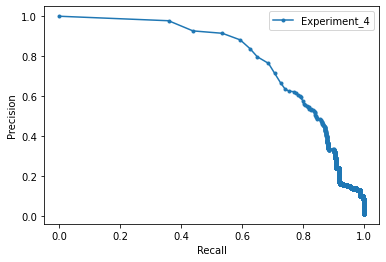

Best Threshold=0.440328, G-Mean=0.972


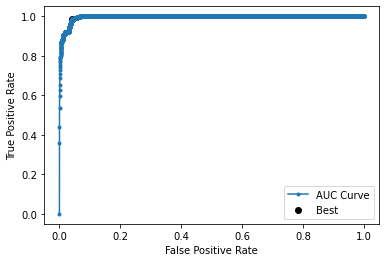

In [12]:
merged_files = merge_eval_files('feature_model/Experiment_4/dev_predictions/')
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
testy = merged_files['evaluation_label'].replace({-1:0})
lr_probs = merged_files['siamese_prediction']
lr_precision, lr_recall, _ = precision_recall_curve(testy.ravel(), lr_probs.ravel())
# , lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Experiment_4')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()
from numpy import sqrt, argmax
fpr, tpr, thresholds = roc_curve(testy, lr_probs)
#gmeans = 2*fpr*tpr / (fpr + tpr)
#print(gmeans)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
pyplot.plot(fpr, tpr, marker='.', label='AUC Curve')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [9]:
def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    
    for i in y_true.index: 
        try:
            if y_true[i]==y_pred[i]==1:
               TP += 1
            if y_pred[i]==1 and y_true[i]!=y_pred[i]:
               FP += 1
            if y_pred[i]==0 and y_true[i]!=y_pred[i]:
               FN += 1
        except:
            print(y_true[i], y_pred[i])
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    # print(TP, FP, FN)
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall
#precision, recall = calc_precision_recall(testy, lr_probs)

In [25]:
probability_thresholds = np.linspace(0, 1, num=1000)
len(probability_thresholds)

1000

In [29]:
# probability_thresholds[:-30]

In [ ]:
print(sklearn.metrics.classification_report(y_test, y_test_probs))

In [10]:
precision_scores = []
recall_scores = []
precision_scores_1 = []
recall_scores_1 = []
y_test_probs = lr_probs
y_test = testy
# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=500)
y_test = y_test.reset_index(drop = True)
y_test_probs = y_test_probs.reset_index(drop = True)
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    #precision, recall = sklearn.metrics.precision_score(y_test, y_test_preds), sklearn.metrics.recall_score(y_test, y_test_preds)
    precision_1, recall_1 = calc_precision_recall(y_test, y_test_preds)
    
    precision_scores.append(precision_1)
    recall_scores.append(recall_1)
    #precision_scores_1.append(precision_1)
    #recall_scores_1.append(recall_1)

In [12]:
len(recall_scores)

500

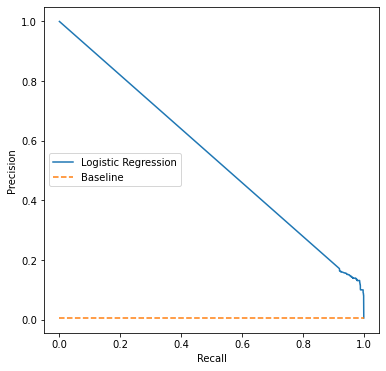

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='Logistic Regression')
# ax.plot(l2_recall_scores, l2_precision_scores, label='L2 Logistic Regression')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

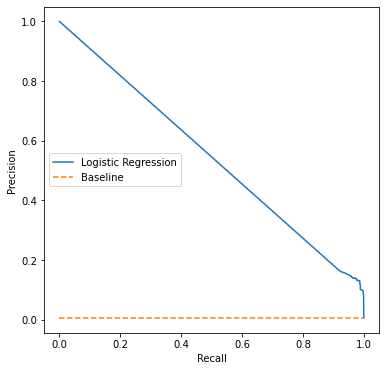

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores_1, precision_scores_1, label='Logistic Regression')
# ax.plot(l2_recall_scores, l2_precision_scores, label='L2 Logistic Regression')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');